## Задача:

Предложить вариант прогнозной модели по предсказанию задержки рейса авиакомпании на горизонте 24 часа;

предполагается, что модель будет запускаться раз в сутки и давать прогноз исполнимости расписаний на следующие сутки.

Что хотелось бы получить для оценки:

1. Код Python, отражающий ход обработки данных и построение модели.

2. Краткий отчет в любом формате, содержащий:

· подход к построению модели

· описание предлагаемой модели

· оценку точности предсказания

· краткие выводы и идеи дальнейшего развития модели

#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd

from requests import get
import requests
import json

import datetime
from datetime import datetime, time, timedelta

import pytz
from pytz import timezone
from pytz import common_timezones
from pytz import country_timezones

from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline

from scipy.stats import boxcox, probplot
from scipy.stats import norm

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score

from catboost import CatBoostRegressor, Pool, cv
import xgboost as xgb

In [2]:
import warnings
warnings.simplefilter('ignore')

В качестве метрики будем использовать RMSE, чтобы понимать, на сколько минут ошибаемся в предсказании задержки рейса, и R2, потому что коэффициент детерминации - относительная величина, и по ней можно судить, насколько точно работает модель.

#### Пути к файлам. Загрузка данных

In [3]:
TEST_PATH = 'Тестовое задание_schedule_dataset.xlsx'

In [4]:
data = pd.read_excel(TEST_PATH)
data.head()

,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время отправления по расписанию,Время отправления фактическое,Время прибытия по расписанию,Время прибытия фактическое
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


In [5]:
data = data.reset_index()

## Обзор данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139732 entries, 0 to 139731
Data columns (total 10 columns):
index                              139732 non-null int64
Дата рейса                         139732 non-null datetime64[ns]
Рейс                               139732 non-null int64
А/П отправл                        139732 non-null object
А/П прибыт                         139732 non-null object
Номер ВС                           139732 non-null int64
Время отправления по расписанию    139732 non-null datetime64[ns]
Время отправления фактическое      139732 non-null datetime64[ns]
Время прибытия по расписанию       139732 non-null datetime64[ns]
Время прибытия фактическое         139732 non-null datetime64[ns]
dtypes: datetime64[ns](5), int64(3), object(2)
memory usage: 10.7+ MB


#### Количество уникальных значений по каждому из признаков

In [7]:
data.nunique().sort_values()

А/П отправл                           157
А/П прибыт                            157
Дата рейса                            187
Номер ВС                              246
Рейс                                 1074
Время отправления по расписанию     49597
Время прибытия по расписанию        50664
Время отправления фактическое      107901
Время прибытия фактическое         109297
index                              139732
dtype: int64

## Предобработка данных и работа с признаками

#### Поскольку аэропорты находятся в разных часовых поясях, требуется внести соответствующие изменения в датасет.

In [8]:
# Создадим словарь с IATA кодами.

req = requests.get('http://api.travelpayouts.com/data/ru/airports.json')
row_data = json.loads(req.text)

time_zone = []
for i in row_data:
    city = (i['city_code'], i['time_zone'])
    port = (i['code'], i['time_zone'])
    time_zone.append(city)
    time_zone.append(port)
time_zone = dict(time_zone)

In [9]:
data['Зона отправл'] = None
for i, j in enumerate(data['А/П отправл']):
    data['Зона отправл'][i] = pytz.timezone(time_zone[j])

In [10]:
data['Зона прибыт'] = None
for i, j in enumerate(data['А/П прибыт']):
    data['Зона прибыт'][i] = pytz.timezone(time_zone[j])

In [11]:
data['Время отправления по расписанию UTC'] = None
for i, j in enumerate(data['Время отправления по расписанию']):
    data['Время отправления по расписанию UTC'][i] = j.tz_localize('UTC').tz_convert(data['Зона отправл'][i])

data['Время отправления фактическое UTC'] = None
for i, j in enumerate(data['Время отправления фактическое']):
    data['Время отправления фактическое UTC'][i] = j.tz_localize('UTC').tz_convert(data['Зона отправл'][i])

In [12]:
data['Время прибытия по расписанию UTC'] = None
for i, j in enumerate(data['Время прибытия по расписанию']):
    data['Время прибытия по расписанию UTC'][i] = j.tz_localize('UTC').tz_convert(data['Зона прибыт'][i])

data['Время прибытия фактическое UTC'] = None
for i, j in enumerate(data['Время прибытия фактическое']):
    data['Время прибытия фактическое UTC'][i] = j.tz_localize('UTC').tz_convert(data['Зона прибыт'][i])

In [13]:
data.head()

,index,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время отправления по расписанию,Время отправления фактическое,Время прибытия по расписанию,Время прибытия фактическое,Зона отправл,Зона прибыт,Время отправления по расписанию UTC,Время отправления фактическое UTC,Время прибытия по расписанию UTC,Время прибытия фактическое UTC
0,0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00,Europe/Moscow,Europe/Moscow,2018-03-01 03:05:00+03:00,2018-03-01 02:48:00+03:00,2018-03-01 05:00:00+03:00,2018-03-01 04:48:00+03:00
1,1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00,Europe/Moscow,Europe/Moscow,2018-03-01 03:05:00+03:00,2018-03-01 03:00:00+03:00,2018-03-01 04:30:00+03:00,2018-03-01 04:55:00+03:00
2,2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00,Europe/Moscow,Asia/Aqtobe,2018-03-01 03:15:00+03:00,2018-03-01 03:14:00+03:00,2018-03-01 07:40:00+05:00,2018-03-01 07:32:00+05:00
3,3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00,Europe/Moscow,Europe/Moscow,2018-03-01 03:20:00+03:00,2018-03-01 03:11:00+03:00,2018-03-01 04:35:00+03:00,2018-03-01 04:39:00+03:00
4,4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00,Europe/Moscow,Europe/Moscow,2018-03-01 03:25:00+03:00,2018-03-01 03:21:00+03:00,2018-03-01 05:40:00+03:00,2018-03-01 05:41:00+03:00


### Создание и анализ целевой переменной

#### Создаем переменные: 'Задержка отправления' и 'Задержка прибытия'

In [14]:
data['Задержка отправления'] = data['Время отправления фактическое UTC'] - data['Время отправления по расписанию UTC']
data['Задержка прибытия'] = data['Время прибытия фактическое UTC'] - data['Время прибытия по расписанию UTC']

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139732 entries, 0 to 139731
Data columns (total 18 columns):
index                                  139732 non-null int64
Дата рейса                             139732 non-null datetime64[ns]
Рейс                                   139732 non-null int64
А/П отправл                            139732 non-null object
А/П прибыт                             139732 non-null object
Номер ВС                               139732 non-null int64
Время отправления по расписанию        139732 non-null datetime64[ns]
Время отправления фактическое          139732 non-null datetime64[ns]
Время прибытия по расписанию           139732 non-null datetime64[ns]
Время прибытия фактическое             139732 non-null datetime64[ns]
Зона отправл                           139732 non-null object
Зона прибыт                            139732 non-null object
Время отправления по расписанию UTC    139732 non-null object
Время отправления фактическое UTC      139732 

#### Приведем тип переменных к вещественным числам и выразим задержку в минутах

In [16]:
data['Задержка отправления'] = list(map(pd.Timedelta.total_seconds, data['Задержка отправления']))
data['Задержка прибытия'] = list(map(pd.Timedelta.total_seconds, data['Задержка прибытия']))

data['Задержка отправления'] = data['Задержка отправления'].astype(np.float) / 60
data['Задержка прибытия'] = data['Задержка прибытия'].astype(np.float) / 60

Посмотрим на графике, как распределены обе переменные

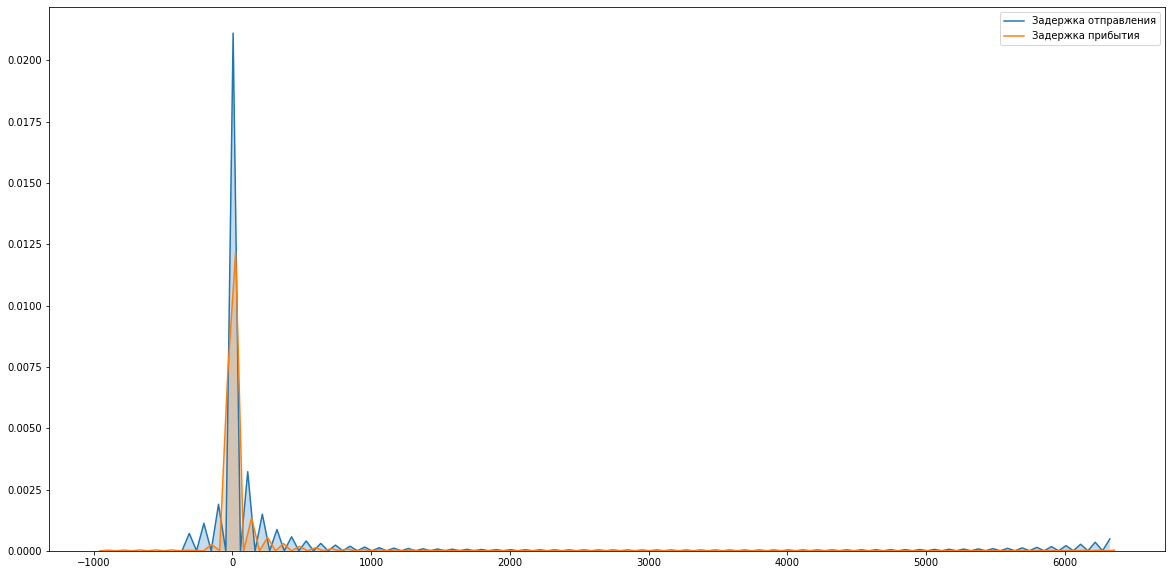

In [17]:
plt.figure(figsize=(20,10))
sns.kdeplot(data['Задержка отправления'], shade=True)
sns.kdeplot(data['Задержка прибытия'], shade=True)

plt.legend();

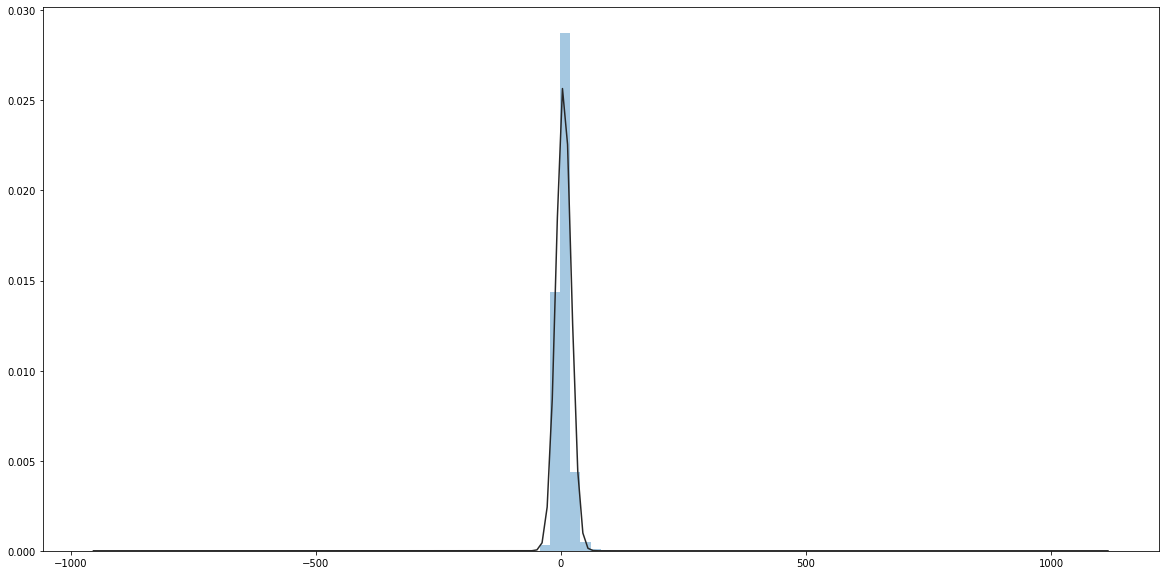

In [18]:
gap = data['Задержка прибытия'] - data['Задержка отправления']
plt.figure(figsize=(20,10))
sns.distplot(gap, bins=100, kde=False, fit=norm);

In [19]:
gap.describe()

count    139732.000000
mean          5.765687
std          15.380439
min        -949.000000
25%          -2.000000
50%           4.000000
75%          12.000000
max        1112.000000
dtype: float64

Мы видим, что данные содержат выбросы. Видимо, экстремальные значения переменных вызваны форсмажорными обстоятельствами, которые не поддаются предсказанию и будут негативно влиять на качество модели.

Примем за целевую переменную задержку прибытия, поскольку в конечном итоге именно она указывает на задержку рейса. Если же требуется предсказать обе переменные, то задержка отправления будет рассчитываться аналогично.

In [20]:
TARGET_NAME = 'Задержка прибытия'

### Анализ целевой переменной

In [21]:
data[TARGET_NAME].describe()

count    139732.000000
mean          2.990868
std          51.605647
min        -953.000000
25%          -9.000000
50%          -2.000000
75%           6.000000
max        6355.000000
Name: Задержка прибытия, dtype: float64

#### QQ plot для сравнения с нормальным распределением

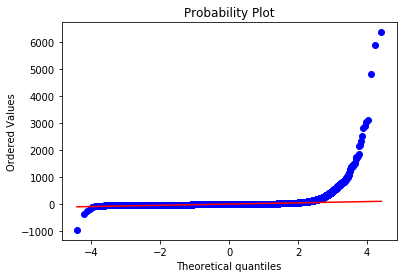

In [22]:
f, ax = plt.subplots()
probplot(data[TARGET_NAME], plot=ax);

На графике видно, что распределение целевой переменной очень близко к нормальному, но картину портят выбросы.

In [23]:
quantile = data.loc[
    (data[TARGET_NAME] > data[TARGET_NAME].quantile(0.001)) & (data[TARGET_NAME] < data[TARGET_NAME].quantile(0.97))
                   ]

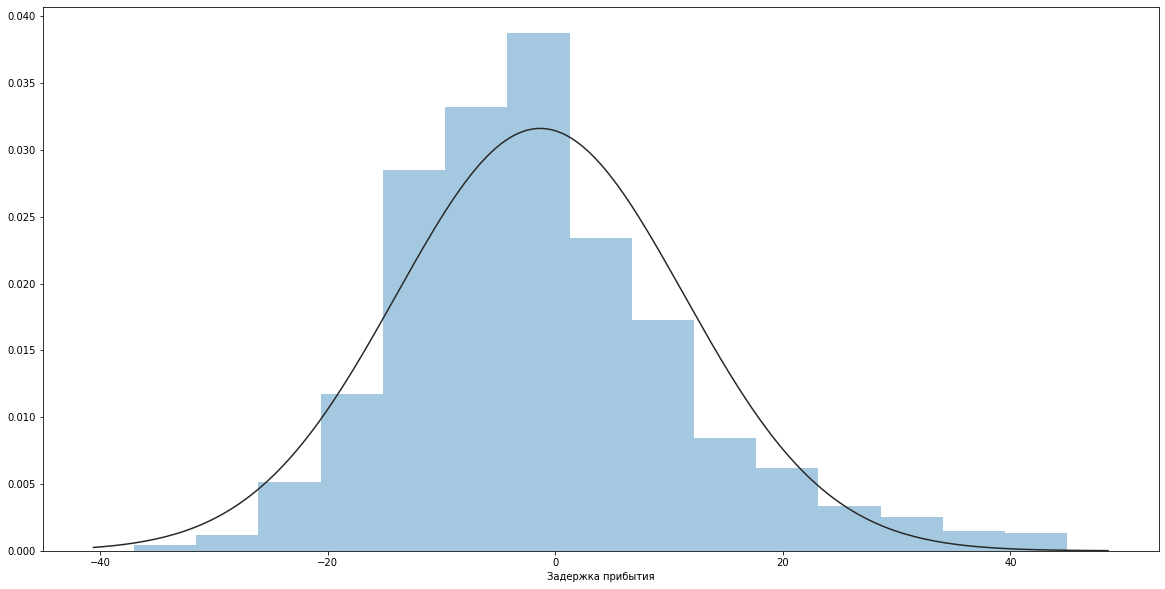

In [24]:
plt.figure(figsize=(20,10))
sns.distplot(quantile[TARGET_NAME], bins=15, kde=False, fit=norm);

При попытке избавиться от выбросов в целевой переменной путем замены экстремальных значений на значения 0.001 и 0.97 квантилей качество предсказания ухудшилось почти в два раза.

## Разбиение на train и test

In [25]:
def split_data(data, split_index):
    '''
    Разбиваем датасет на два набора данных по индексу
    '''
    return data.loc[data['index'] <= split_index].copy(), \
           data.loc[data['index'] >  split_index].copy()

In [26]:
train, test = split_data(data, data.shape[0] * 0.70)

In [27]:
train.shape

(97813, 18)

In [28]:
test.shape

(41919, 18)

### Создание новых признаков и формирование списков признаков

#### Добавим календарь в датасет

#### Создадим признаки 'День недели' и 'Час'

In [29]:
# train['Месяц'] = train['Время отправления по расписанию'].dt.month
train['Неделя в году'] = train['Время отправления по расписанию'].dt.weekofyear
train['День недели'] = train['Время отправления по расписанию'].dt.dayofweek
train['Час'] = train['Время отправления по расписанию'].dt.hour

#### Создадим переменную 'Длительность перелета'. 

In [31]:
train['Длительность перелета'] = train['Время прибытия по расписанию'] - train['Время отправления по расписанию']
train['Длительность перелета'] = list(map(pd.Timedelta.total_seconds, train['Длительность перелета']))
train['Длительность перелета'] = train['Длительность перелета'].astype(np.float) / 60

#### Добавим количество рейсов в день

In [32]:
flights_per_day = data.groupby('Дата рейса')['index'].count()
flights_per_day = pd.DataFrame(flights_per_day).rename(columns={'index': 'Число рейсов в день'}).reset_index()

train = train.merge(flights_per_day, on='Дата рейса', how='left')

#### Посчитаем частоту каждого рейса

In [33]:
qnt_of_flights = train.groupby('Рейс')['index'].count() 
qnt_of_flights = pd.DataFrame(qnt_of_flights).rename(columns={'index': 'Число рейсов'}).reset_index()
qnt_of_flights['Частота рейса'] = qnt_of_flights['Число рейсов'] / train['Дата рейса'].nunique()

train = train.merge(qnt_of_flights, on='Рейс', how='left')

#### Посчитаем медианное значение для опоздания рейсов и создадим соответствующий признак

In [34]:
flight = train.groupby(['Рейс'])[TARGET_NAME].median()
flight = pd.DataFrame(flight).rename(columns={'Задержка прибытия': 'Средняя задержка рейса'}).reset_index()

train = train.merge(flight, on='Рейс', how='left')

#### Посчитаем медиану для задержки  в зависимости от аэропорта отправления

In [35]:
departure = train.groupby(['А/П отправл'])[TARGET_NAME].median()
departure = pd.DataFrame(departure).rename(columns={'Задержка прибытия': 'Средняя задержка из аэропорта'}).reset_index()

train = train.merge(departure, on='А/П отправл', how='left')

#### Посчитаем медиану для задержки в зависимости от аэропорта прибытия

In [36]:
arrival = train.groupby(['А/П прибыт'])[TARGET_NAME].median()
arrival = pd.DataFrame(arrival).rename(columns={'Задержка прибытия': 'Средняя задержка в аэропорт'}).reset_index()

train = train.merge(arrival, on='А/П прибыт', how='left')

#### Посчитаем медиану для задержки в зависимости от воздушного средства

In [37]:
plane = train.groupby(['Номер ВС'])[TARGET_NAME].median()
plane = pd.DataFrame(plane).rename(columns={'Задержка прибытия': 'Средняя задержка воздушного средства'}).reset_index()

train = train.merge(plane, on='Номер ВС', how='left')

### Приведение типов

Поля 'Рейс', 'Номер ВС', очевидно, категориальные признаки.

In [38]:
train['Рейс'] = train['Рейс'].astype('object')
train['Номер ВС'] = train['Номер ВС'].astype('object')

### Списки признаков

#### Список количественных признаков

In [39]:
NUM_FEATURE_NAMES = train.select_dtypes(include=['int64', 'float64']).drop(
    columns=['Задержка отправления', 'Задержка прибытия', 'index']).columns.tolist()
NUM_FEATURE_NAMES

['Неделя в году',
 'День недели',
 'Час',
 'Длительность перелета',
 'Число рейсов в день',
 'Число рейсов',
 'Частота рейса',
 'Средняя задержка рейса',
 'Средняя задержка из аэропорта',
 'Средняя задержка в аэропорт',
 'Средняя задержка воздушного средства']

#### Список категориальных признаков

In [40]:
CAT_FEATURE_NAMES = train.select_dtypes(include='object').drop(columns=['Зона отправл',
 'Зона прибыт',
 'Время отправления по расписанию UTC',
 'Время отправления фактическое UTC',
 'Время прибытия по расписанию UTC',
 'Время прибытия фактическое UTC']).columns.tolist()

CAT_FEATURE_NAMES

['Рейс', 'А/П отправл', 'А/П прибыт', 'Номер ВС']

#### Список временных признаков

In [41]:
TIME_FEATURE_NAMES = train.select_dtypes(
    include=['datetime64', 'timedelta64']).columns.tolist()

TIME_FEATURE_NAMES

['Дата рейса',
 'Время отправления по расписанию',
 'Время отправления фактическое',
 'Время прибытия по расписанию',
 'Время прибытия фактическое']

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97813 entries, 0 to 97812
Data columns (total 29 columns):
index                                   97813 non-null int64
Дата рейса                              97813 non-null datetime64[ns]
Рейс                                    97813 non-null object
А/П отправл                             97813 non-null object
А/П прибыт                              97813 non-null object
Номер ВС                                97813 non-null object
Время отправления по расписанию         97813 non-null datetime64[ns]
Время отправления фактическое           97813 non-null datetime64[ns]
Время прибытия по расписанию            97813 non-null datetime64[ns]
Время прибытия фактическое              97813 non-null datetime64[ns]
Зона отправл                            97813 non-null object
Зона прибыт                             97813 non-null object
Время отправления по расписанию UTC     97813 non-null object
Время отправления фактическое UTC       97813 

## Преобразуем тест

In [43]:
def change_test(test):
    '''
    Приводим тестовую выборку в соответствие с трейном
    '''
#     Календарь
#     test['Месяц'] = test['Время отправления по расписанию'].dt.month
    test['Неделя в году'] = test['Время отправления по расписанию'].dt.weekofyear
    test['День недели'] = test['Время отправления по расписанию'].dt.dayofweek
    test['Час'] = test['Время отправления по расписанию'].dt.hour
#     Длительность перелета
    test['Длительность перелета'] = test['Время прибытия по расписанию'] - test['Время отправления по расписанию']
    test['Длительность перелета'] = list(map(pd.Timedelta.total_seconds, test['Длительность перелета']))
    test['Длительность перелета'] = test['Длительность перелета'].astype(np.float) / 60
#     Количество рейсов в день
    test = test.merge(flights_per_day, on='Дата рейса', how='left')
# #     Частота рейсов
    test = test.merge(qnt_of_flights, on='Рейс', how='left')
#     Задержка рейса
    test = test.merge(flight, on='Рейс', how='left')
#     Задержка аэропорта отправления
    test = test.merge(departure, on='А/П отправл', how='left')
#     Задержка аэропорта прибытия
    test = test.merge(arrival, on='А/П прибыт', how='left')
#     Задержка воздушного средства
    test = test.merge(plane, on='Номер ВС', how='left')
#     Приведение к категориальному типу
    test['Рейс'] = test['Рейс'].astype('object')
    test['Номер ВС'] = test['Номер ВС'].astype('object')
    
    return test

In [44]:
test = change_test(test)

In [45]:
test.isnull().sum()

index                                     0
Дата рейса                                0
Рейс                                      0
А/П отправл                               0
А/П прибыт                                0
Номер ВС                                  0
Время отправления по расписанию           0
Время отправления фактическое             0
Время прибытия по расписанию              0
Время прибытия фактическое                0
Зона отправл                              0
Зона прибыт                               0
Время отправления по расписанию UTC       0
Время отправления фактическое UTC         0
Время прибытия по расписанию UTC          0
Время прибытия фактическое UTC            0
Задержка отправления                      0
Задержка прибытия                         0
Неделя в году                             0
День недели                               0
Час                                       0
Длительность перелета                     0
Число рейсов в день             

Заполним пропуски медианами, поскольку медианные значения менее чувствительны к выбросам.

In [46]:
def fill_missing_values(train, test, NUM_FEATURE_NAMES):
    '''
    Заменяет пропуски в количественных признаках медианой
    '''
    imputer = SimpleImputer(strategy="median")
    imputer.fit(train[NUM_FEATURE_NAMES].values)
    test[NUM_FEATURE_NAMES] = imputer.transform(test[NUM_FEATURE_NAMES].values)

In [47]:
fill_missing_values(train, test, NUM_FEATURE_NAMES)

In [48]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41919 entries, 0 to 41918
Data columns (total 29 columns):
index                                   41919 non-null int64
Дата рейса                              41919 non-null datetime64[ns]
Рейс                                    41919 non-null object
А/П отправл                             41919 non-null object
А/П прибыт                              41919 non-null object
Номер ВС                                41919 non-null object
Время отправления по расписанию         41919 non-null datetime64[ns]
Время отправления фактическое           41919 non-null datetime64[ns]
Время прибытия по расписанию            41919 non-null datetime64[ns]
Время прибытия фактическое              41919 non-null datetime64[ns]
Зона отправл                            41919 non-null object
Зона прибыт                             41919 non-null object
Время отправления по расписанию UTC     41919 non-null object
Время отправления фактическое UTC       41919 

### Матрица корреляций

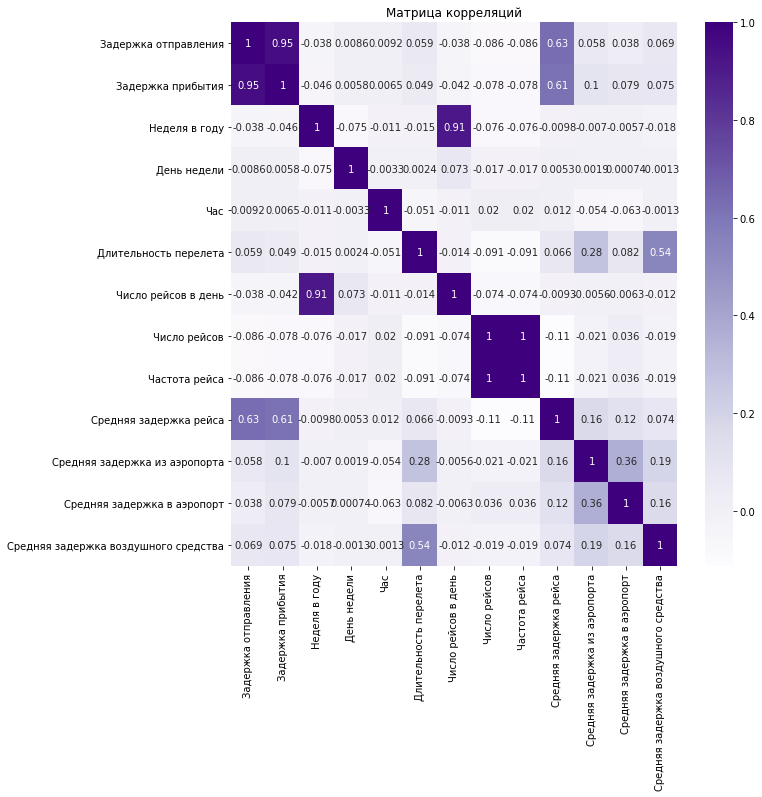

In [49]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.drop('index', axis=1).corr(), cmap='Purples', annot=True)
plt.title('Матрица корреляций');

In [50]:
X_train = train.drop(columns=['Дата рейса', 
                              'Задержка отправления', 
                              'Задержка прибытия',
                              'Время отправления по расписанию',
                              'Время отправления фактическое',
                              'Время прибытия по расписанию',
                              'Время прибытия фактическое', 
                              'Зона отправл', 
                              'Зона прибыт', 
                              'Время отправления по расписанию UTC', 
                              'Время отправления фактическое UTC', 
                              'Время прибытия по расписанию UTC', 
                              'Время прибытия фактическое UTC'])

y_train = train[TARGET_NAME]

In [51]:
X_test = test.drop(columns=['Дата рейса', 
                              'Задержка отправления', 
                              'Задержка прибытия',
                              'Время отправления по расписанию',
                              'Время отправления фактическое',
                              'Время прибытия по расписанию',
                              'Время прибытия фактическое', 
                              'Зона отправл', 
                              'Зона прибыт', 
                              'Время отправления по расписанию UTC', 
                              'Время отправления фактическое UTC', 
                              'Время прибытия по расписанию UTC', 
                              'Время прибытия фактическое UTC'])

y_test = test[TARGET_NAME]

In [52]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41919 entries, 0 to 41918
Data columns (total 16 columns):
index                                   41919 non-null int64
Рейс                                    41919 non-null object
А/П отправл                             41919 non-null object
А/П прибыт                              41919 non-null object
Номер ВС                                41919 non-null object
Неделя в году                           41919 non-null float64
День недели                             41919 non-null float64
Час                                     41919 non-null float64
Длительность перелета                   41919 non-null float64
Число рейсов в день                     41919 non-null float64
Число рейсов                            41919 non-null float64
Частота рейса                           41919 non-null float64
Средняя задержка рейса                  41919 non-null float64
Средняя задержка из аэропорта           41919 non-null float64
Средняя задержк

#### Сохраняем наборы данных для CatBoost перед обработкой категориальных признаков

In [53]:
X_train_cat = X_train.drop('index', axis=1).copy()
X_test_cat = X_test.drop('index', axis=1).copy()

### Обработка категориальных признаков

In [54]:
CAT_FEATURE_NAMES

['Рейс', 'А/П отправл', 'А/П прибыт', 'Номер ВС']

In [55]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

dummies = pd.DataFrame(enc.fit_transform(X_train[CAT_FEATURE_NAMES])).reset_index()
dummies_test = pd.DataFrame(enc.transform(X_test[CAT_FEATURE_NAMES])).set_index(
    np.arange(test.iloc[0, 0], test.iloc[-1, 0]+1)).reset_index()

X_train = X_train.merge(dummies, on='index', how='left').drop(columns=CAT_FEATURE_NAMES, axis=1)
X_test = X_test.merge(dummies_test, on='index', how='left').drop(columns=CAT_FEATURE_NAMES, axis=1)

In [56]:
X_train = X_train.set_index('index')
X_test = X_test.set_index('index')

### Стандартизация признаков

In [57]:
scaler = StandardScaler()

In [58]:
X_train[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train[NUM_FEATURE_NAMES])
X_test[NUM_FEATURE_NAMES] = scaler.transform(X_test[NUM_FEATURE_NAMES])

# Выбор модели

In [59]:
def train_model(model, X_train, y_train, X_test, y_test):
    '''
    Модель обучается на трейне, предсказывает на трейне и тесте, 
    выдает значения RMSE и R2 для трейна и теста
    '''
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print("train_RMSE: {}".format(np.sqrt(mean_squared_error((y_train), (y_pred_train)))))
    print("test_RMSE: {}".format(np.sqrt(mean_squared_error((y_test), (y_pred_test)))))
    print()
    print("train_R2: {}".format(r2_score((y_train), (y_pred_train))))
    print("test_R2: {}".format(r2_score((y_test), (y_pred_test))))

## Линейные модели

#### LinearRegression

In [60]:
linreg = LinearRegression()
train_model(linreg, X_train, y_train, X_test, y_test)

train_RMSE: 34.62274489932542
test_RMSE: 621936220.7438135

train_R2: 0.5468242664771579
test_R2: -143238025367088.8


#### LassoCV

In [61]:
tscv = TimeSeriesSplit(n_splits=5)  # Разбиваем датасет, сохраняя временную структуру
cv = tscv.split(X_train)

lasso_cv = LassoCV(random_state=5, cv=cv)
train_model(lasso_cv, X_train, y_train, X_test, y_test)

train_RMSE: 41.7304731251613
test_RMSE: 48.639526967038336

train_R2: 0.34165995645146807
test_R2: 0.12391688513748922


In [62]:
lasso_cv.alpha_

9.641228834321

In [63]:
L1_coef = pd.DataFrame(lasso_cv.coef_, index=X_train.columns, 
                       columns=['weight']).sort_values(by='weight', ascending=False)

In [64]:
L1_coef.loc[abs(L1_coef['weight'].values) > 0]

,weight
Средняя задержка рейса,21.929449


L1 регуляризацию можно сипользовать для отбора признаков, но в этом случае обнулились коэффициенты всех признаков, кроме одного.

#### RidgeCV

In [65]:
cv = tscv.split(X_train)  # Разбиваем датасет, сохраняя временную структуру

ridge_cv = RidgeCV(cv=cv)
train_model(ridge_cv, X_train, y_train, X_test, y_test)

train_RMSE: 39.62697840280477
test_RMSE: 47.669687729950525

train_R2: 0.40635669941455765
test_R2: 0.15850558333491405


In [66]:
ridge_cv.alpha_

10.0

## Ансамблевые модели

#### RandomForestRegressor

In [67]:
rf = RandomForestRegressor(n_jobs=-1, 
                            random_state=5)

In [68]:
train_model(rf, X_train, y_train, X_test, y_test)

train_RMSE: 16.217698945385205
test_RMSE: 49.7473525334841

train_R2: 0.9005689276962872
test_R2: 0.08355465124000028


In [69]:
feature_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': rf.feature_importances_}
 )
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances.head(20)

,feature,importance
7,Средняя задержка рейса,0.383435
4,Число рейсов в день,0.073965
0,Неделя в году,0.053627
1178,1167,0.052732
1,День недели,0.036301
3,Длительность перелета,0.024365
2,Час,0.019806
10,Средняя задержка воздушного средства,0.014914
1552,1541,0.010417
1536,1525,0.008903


In [70]:
best_features = feature_importances['feature'].values[:20]

In [71]:
# train_model(rf, X_train[best_features], y_train, X_test[best_features], y_test)

#### GradientBoostingRegressor

In [72]:
# gbr = GradientBoostingRegressor(random_state=5)

In [73]:
# train_model(rf, X_train, y_train, X_test, y_test)

Градиентный бустинг от sk-learn дает совершенно такой же результат, как и RandomForest.

#### XGBoost

In [74]:
xgbr = xgb.XGBRegressor(random_state=1, objective='reg:squarederror', n_jobs=-1)

In [75]:
train_model(xgbr, X_train, y_train, X_test, y_test)

train_RMSE: 33.974832784791005
test_RMSE: 45.67546038906074

train_R2: 0.5636265587609078
test_R2: 0.22743951353691094


In [76]:
xgbr.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)>

#### CatBoostRegressor

In [77]:
catb = CatBoostRegressor(silent=True, random_seed=5, cat_features=CAT_FEATURE_NAMES)

In [78]:
train_model(catb, X_train_cat, y_train, X_test_cat, y_test)

train_RMSE: 33.29534301027751
test_RMSE: 46.23021310369781

train_R2: 0.580906773805149
test_R2: 0.2085592356200241


#### Лучший результат показала модель XGBoostRegressor

## Настройка параметров лучшей модели

In [79]:
tscv = TimeSeriesSplit(n_splits=5)  # Разбиваем датасет, сохраняя временную структуру
cv = tscv.split(X_train)

In [80]:
model = xgb.XGBRegressor(random_seed=5, objective='reg:squarederror', n_jobs=-1)

grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'reg_alpha': [0.0, 0.01, 0.1],
    'reg_lambda': [1.0, 5.0, 3.0, 7.0],
    'gamma': np.linspace(0.0, 0.5, 5)
}

gscv = RandomizedSearchCV(model, grid, cv=cv, n_iter=30)

In [81]:
train_model(gscv, X_train, y_train, X_test, y_test)

train_RMSE: 36.3413712952103
test_RMSE: 45.20181156432709

train_R2: 0.5007175780335635
test_R2: 0.24337914846159425


In [100]:
params = gscv.best_estimator_.get_params()

#### Обучим оптимизированную модель на всем трейне

In [101]:
xgbr = xgb.XGBRegressor(**params)

In [102]:
train_model(xgbr, X_train, y_train, X_test, y_test)

train_RMSE: 36.3413712952103
test_RMSE: 45.20181156432709

train_R2: 0.5007175780335635
test_R2: 0.24337914846159425


### Построим интервалы, в которых с вероятностью 95,4% будут лежать предсказания

Разобьем X_train на две выборки. На первой обучим модель для предсказания целевой переменной, а на второй - модель для предсказания MSE.

In [103]:
X1, X2 = split_data(pd.concat([X_train, y_train], axis=1).reset_index(), X_train.shape[0] * 0.50)

In [104]:
y1 = X1[TARGET_NAME]
X1 = X1.drop([TARGET_NAME, 'index'], axis=1)

In [105]:
y2 = X2[TARGET_NAME]
X2 = X2.drop([TARGET_NAME, 'index'], axis=1)

In [106]:
xgbr_mean = xgb.XGBRegressor(**params)

In [107]:
xgbr_mean.fit(X1, y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.375,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_seed=5, random_state=0, reg_alpha=0.01, reg_lambda=5.0,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [108]:
y2_pred = xgbr_mean.predict(X2)

In [109]:
y2_pred_error = (y2 - y2_pred) ** 2

In [110]:
xgbr_std = xgb.XGBRegressor(**params)

In [111]:
xgbr_std.fit(X2, y2_pred_error)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.375,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_seed=5, random_state=0, reg_alpha=0.01, reg_lambda=5.0,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [112]:
y_test_mean = xgbr_mean.predict(X_test)

In [113]:
y_test_std = xgbr_std.predict(X_test)

Квадратный среднеквадратичная ошибка - это дисперсия целевой переменной, поэтому можно найти интервал +/- 2$\sigma$ и построить интервал, который с вероятностью 95,4% покроет целевую переменную.

In [114]:
results = pd.DataFrame()
results['predict_lower'] = y_test_mean - (2*(y_test_std)**0.5)
results['predict'] = y_test_mean
results['predict_upper'] = y_test_mean + (2*(y_test_std)**0.5)

In [115]:
results.head()

,predict_lower,predict,predict_upper
0,-51.824802,1.398746,54.622295
1,-51.103382,2.120167,55.343716
2,-51.016048,2.207502,55.431049
3,-54.361526,-1.137977,52.085571
4,-49.734203,3.489346,56.712894


Мы получили модель, которая предсказывает целевую переменную и строит 95,4% доверительный интервал.

Далее мы можем сделать сервер с использованием, например, библиотеки Flask, перенести во Flask все функции преобразования данных, загрузить обученные модели, настроить логирование и далее использовать для прогнозирования на новых данных.